# 📊 SyriaTel Customer Churn Prediction

Welcome to this end-to-end data science project focused on customer churn prediction for **SyriaTel**, a telecommunications company.

## 🧠 Problem Understanding

**Business Objective:**  
SyriaTel wants to proactively identify customers likely to **churn** (stop using their services), so they can intervene and reduce revenue loss.

**Technical Objective:**  
This is a binary classification task — I aim to train a model that accurately predicts whether a customer will churn based on historical data.




In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.feature_selection import SelectKBest, f_classif

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


All the necessary Python libraries for data manipulation, visualization, and machine learning have been imported at the start. Their usage will become clear as we move through each stage of the pipeline.


## 📥 Data Loading and Initial Exploration

Before diving into preprocessing or modeling, we start by loading the dataset and gaining an initial understanding of its structure.

Key steps in this section:
- Load the data from a CSV file
- Inspect the dataset shape and column types
- Preview the first few rows
- Check for any missing values
- Generate basic descriptive statistics


In [ ]:
# Load the dataset
df = pd.read_csv('Data/telecom.csv')

In [10]:
df.shape

(3333, 21)

The dataset contains `3,333 rows` and `21 columns`, which indicates a medium-sized dataset suitable for detailed analysis and modeling.


In [8]:
df.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

We observe:
- Most features are numerical, with a few categorical ones (`state`, `international plan`, `voice mail plan`, etc.).
- The target variable is `churn`, stored as a boolean.
- `phone number` and `state` may not be useful for prediction and could be dropped later.


In [11]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Looking at the first five rows gives us a glimpse of how the data is structured. We can already spot columns like `total day minutes`, `total intl charge`, and `customer service calls` which may be predictive of churn.


In [12]:
df.isnull().sum()  

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

There are **no missing values** in the dataset. This saves us the effort of imputing or removing records at this stage.


In [13]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Descriptive statistics reveal:
- `account length` ranges from 1 to 243 days.
- `customer service calls` varies from 0 to 9, which might indicate dissatisfaction.
- Call and charge distributions vary across time periods (day, evening, night, international), and some values are skewed (e.g., `total intl calls` has a low mean).

These insights help us begin feature selection and transformation decisions in upcoming steps.


## 🎯 Target Variable Analysis

Understanding the distribution of our target variable (`churn`) is crucial for:

- Identifying class imbalance  
- Setting appropriate evaluation metrics  
- Understanding the business context  


In [17]:
churn_counts = df['churn'].value_counts()
churn_counts

churn
False    2850
True      483
Name: count, dtype: int64

In [18]:
churn_percentages = df['churn'].value_counts(normalize=True) * 100
churn_percentages

churn
False    85.508551
True     14.491449
Name: proportion, dtype: float64

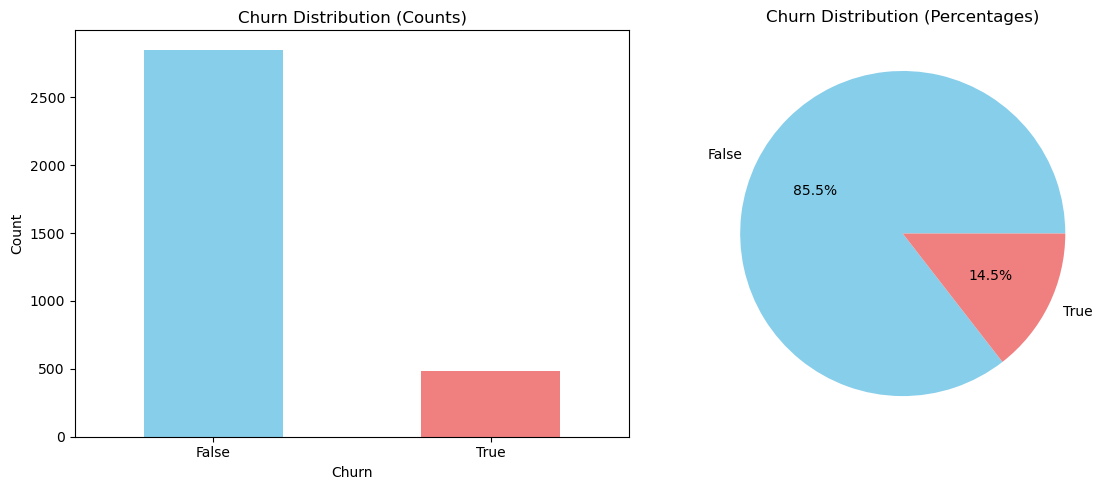

In [22]:
# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
churn_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Churn Distribution (Counts)')
ax1.set_xlabel('Churn')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(churn_percentages.values, labels=churn_counts.index, autopct='%1.1f%%', 
        colors=['skyblue', 'lightcoral'])
ax2.set_title('Churn Distribution (Percentages)')

plt.tight_layout()
plt.show()


The minority class (churned customers) makes up only 14.5% of the data, indicating class imbalance. To address this, techniques like `SMOTE`, `class weighting`, or `focused evaluation` metrics should be considered.